In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaratef3221
Your Kaggle Key: ··········


100%|██████████| 155M/155M [00:01<00:00, 148MB/s]


In [17]:
import tensorflow as tf # TensorFlow main library
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Main image data generator to read the images
from tensorflow.keras import models, layers, Sequential # Models layer e.g. Dense, Convolutions, etc.
from tensorflow.keras.applications.vgg16 import VGG16 # Import the pretrained model
import matplotlib.pyplot as plt # Plotting to plot train progress
from sklearn.metrics import classification_report # For Evaluation
import pandas as pd # Pandas for data analysis
import numpy as np # Analysis for numbers
import os # Interacting with the operating system

print(tf.config.list_physical_devices('GPU')) # Checking if tensorflow is using the GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (1167, 2)



,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [4]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())

Classes are: 
[0 1 2]

Classes ditrubution are: 
2    393
1    389
0    385
Name: category, dtype: int64


In [5]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

batch_size = 16  # Adjust based on your RAM capacity

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='image:FILE',
    y_col='category',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='raw'  # Use 'binary' for binary classification
)

test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='image:FILE',
    y_col='category',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='raw'  # Use 'binary' for binary classification
)

Found 817 validated image filenames.
Found 350 validated image filenames.


In [15]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


In [23]:
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(32, activation = "relu"),
    layers.Dense(3, activation = "softmax")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                524352    
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 15241219 (58.14 MB)
Trainable params: 526531 (2.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=10,)

Epoch 1/10
52/52 [==============================] - 5s 60ms/step - loss: 0.9559 - accuracy: 0.5618
Epoch 2/10
52/52 [==============================] - 3s 60ms/step - loss: 0.6391 - accuracy: 0.7674
Epoch 3/10
52/52 [==============================] - 4s 75ms/step - loss: 0.5061 - accuracy: 0.8078
Epoch 4/10
52/52 [==============================] - 3s 59ms/step - loss: 0.4000 - accuracy: 0.8629
Epoch 5/10
52/52 [==============================] - 3s 61ms/step - loss: 0.3410 - accuracy: 0.8825
Epoch 6/10
52/52 [==============================] - 4s 77ms/step - loss: 0.2740 - accuracy: 0.9229
Epoch 7/10
52/52 [==============================] - 3s 60ms/step - loss: 0.2368 - accuracy: 0.9388
Epoch 8/10
52/52 [==============================] - 3s 60ms/step - loss: 0.2020 - accuracy: 0.9596
Epoch 9/10
52/52 [==============================] - 4s 71ms/step - loss: 0.1686 - accuracy: 0.9645
Epoch 10/10
52/52 [==============================] - 4s 66ms/step - loss: 0.1421 - accuracy: 0.9804


In [33]:
test_results = model.evaluate(test_generator)
print()
for indx, metric in enumerate(model.metrics_names):
  print("Testing ",metric, ": ", round(test_results[indx], 4))

print()
# predictions = model.predict(test_generator)
# print(classification_report(test_generator.classes,
#                             predictions.argmax(axis=-1),
#                             target_names=test_generator.class_indices))

22/22 [==============================] - 2s 73ms/step - loss: 0.4872 - accuracy: 0.7971

Testing  loss :  0.4872
Testing  accuracy :  0.7971



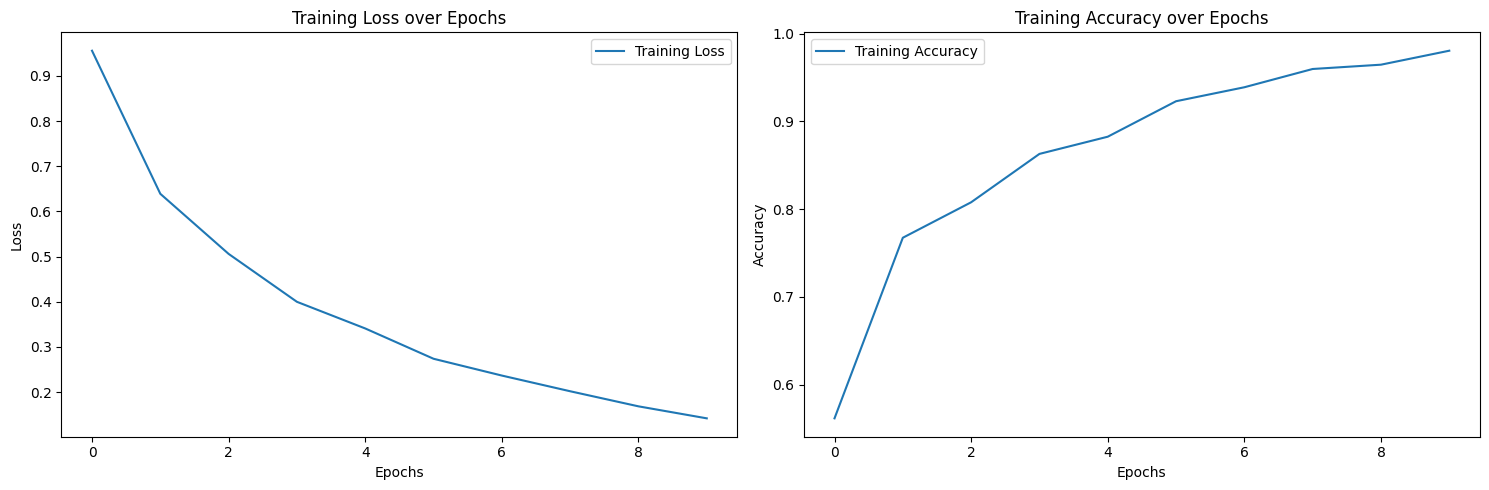

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history.history['loss'], label='Training Loss')
# axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
# axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()